<a href="https://colab.research.google.com/github/amankiitg/GenAI/blob/main/Small_Language_Model_Scratch_Final_Indian_Mythology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Let us build a Small Language Model (SLM) from scratch. We will try to keep the parameter size to 10-15 million.

Our goal is to generate creative and coherent text based on the input data.

## Step 1: Import the Dataset

TinyStories is a synthetic dataset of short stories that only contain words that a typical 3 to 4-year-olds usually understand, generated by GPT-3.5 and GPT-4. We can get it from HuggingFace.

In [1]:
!pip install datasets

In [2]:
!pip install -U datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [3]:
# from datasets import load_dataset

# ds = load_dataset("ombhojane/indian_cultural_raw_dataset")

## Step 2: Tokenize the Dataset

In this step, we will do the following:

(1) Tokenize the dataset into tokenIDs.

(2) Create a file called "train.bin" and "validtion.bin" where we will store the tokenIDs from the entire dataset.

(3) We make sure the tokenIDs are stored on a disk, rather than on the RAM for efficient computations.

In [4]:
# !pip install tiktoken
# import tiktoken
# import os
# import numpy as np
# from tqdm.auto import tqdm

# enc = tiktoken.get_encoding("gpt2")

# # Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py

# def process(example):
#     ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
#     out = {'ids': ids, 'len': len(ids)}
#     return out

# if not os.path.exists("train.bin"):
#     tokenized = ds.map(
#         process,
#         remove_columns=['text'],
#         desc="tokenizing the splits",
#         num_proc=8,
#         )
#     # concatenate all the ids in each dataset into one large file we can use for training
#     for split, dset in tokenized.items():
#         arr_len = np.sum(dset['len'], dtype=np.uint64)
#         filename = f'{split}.bin'
#         dtype = np.uint16 # (can do since enc.max_token_value == 50256 is < 2**16)
#         arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
#         total_batches = 1024

#         idx = 0
#         for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
#             # Batch together samples for faster write
#             batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
#             arr_batch = np.concatenate(batch['ids'])
#             # Write into mmap
#             arr[idx : idx + len(arr_batch)] = arr_batch
#             idx += len(arr_batch)
#         arr.flush()


In [5]:
from datasets import load_dataset
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

# Load the raw dataset
ds = load_dataset("ombhojane/indian_cultural_raw_dataset", split="train")

# Split into 80% train and 20% validation
split_ds = ds.train_test_split(test_size=0.2, seed=42)
train_ds = split_ds["train"]
val_ds = split_ds["test"]

enc = tiktoken.get_encoding("gpt2")

def process(example):
    ids = enc.encode_ordinary(example['text'])  # encode_ordinary ignores special tokens
    return {'ids': ids, 'len': len(ids)}

def tokenize_and_save(dset, split_name, dtype=np.uint16, total_batches=1024):
    # Tokenize the dataset
    tokenized = dset.map(
        process,
        remove_columns=['text'],
        desc=f"Tokenizing {split_name} split",
        num_proc=8,
    )

    arr_len = np.sum(tokenized['len'], dtype=np.uint64)
    filename = f'{split_name}.bin'
    arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))

    idx = 0
    for batch_idx in tqdm(range(total_batches), desc=f'Writing {filename}'):
        batch = tokenized.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
        arr_batch = np.concatenate(batch['ids'])
        arr[idx:idx + len(arr_batch)] = arr_batch
        idx += len(arr_batch)

    arr.flush()

if not (os.path.exists("train.bin") and os.path.exists("validation.bin")):
    tokenize_and_save(train_ds, "train")
    tokenize_and_save(val_ds, "validation")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/710 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/97 [00:00<?, ?it/s]

Bharata%20Mahabharata.txt:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

Kurukshetra%20War.txt:   0%|          | 0.00/45.2k [00:00<?, ?B/s]

Andhra%20Mahabharatam.txt:   0%|          | 0.00/11.7k [00:00<?, ?B/s]

Avanti%20kingdom%20Mahabharata.txt:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Gandhari%20Mahabharata.txt:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

Krishna%20in%20the%20Mahabharata.txt:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

Amba%20Mahabharata.txt:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

Ambika%20Mahabharata.txt:   0%|          | 0.00/5.66k [00:00<?, ?B/s]

Kalinga%20Mahabharata.txt:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

Bhanumati%20wife%20of%20Duryodhana.txt:   0%|          | 0.00/9.97k [00:00<?, ?B/s]

Bharatayuddha.txt:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

Chinas.txt:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Khasas%20Mahabharata.txt:   0%|          | 0.00/4.25k [00:00<?, ?B/s]

Bahlika%20Mahabharata.txt:   0%|          | 0.00/6.28k [00:00<?, ?B/s]

Avatars%20in%20the%20Mahabharata.txt:   0%|          | 0.00/5.49k [00:00<?, ?B/s]

(…)0characters%20in%20the%20Mahabharata.txt:   0%|          | 0.00/102k [00:00<?, ?B/s]

Mahabharata%20Tatparya%20Nirnaya.txt:   0%|          | 0.00/7.66k [00:00<?, ?B/s]

Mahabharata%20disambiguation.txt:   0%|          | 0.00/2.83k [00:00<?, ?B/s]

Mahabharata%20Rajagopalachari%20book.txt:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

The%20Mahabharata%201989%20film.txt:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

Mahabharata.txt:   0%|          | 0.00/87.7k [00:00<?, ?B/s]

Mahabharata%20comics.txt:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

Uttara%20Mahabharata.txt:   0%|          | 0.00/5.59k [00:00<?, ?B/s]

The%20Mahabharata%20Secret.txt:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Pa%C3%B1c%C4%81la.txt:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

Manipura%20Mahabharata.txt:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

The%20Mahabharata%20Narayan%20book.txt:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

(…)adaptations%20of%20the%20Mahabharata.txt:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

The%20Mahabharata%20play.txt:   0%|          | 0.00/8.32k [00:00<?, ?B/s]

Uttar%C4%81%20Mahabharata.txt:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

Sakas%20in%20the%20Mahabharata.txt:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

1.txt:   0%|          | 0.00/7.85k [00:00<?, ?B/s]

Ramana%20Maharshi.txt:   0%|          | 0.00/97.2k [00:00<?, ?B/s]

(…)cal%20weapons%20and%20their%20powers.txt:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

love.txt:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Ramayana.txt:   0%|          | 0.00/77.1k [00:00<?, ?B/s]

Sita.txt:   0%|          | 0.00/84.5k [00:00<?, ?B/s]

ramayanalistofcharacters.txt:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

Randamoozham.txt:   0%|          | 0.00/18.4k [00:00<?, ?B/s]

puran1.txt:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

Maya%20Sita.txt:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

2.txt:   0%|          | 0.00/3.60k [00:00<?, ?B/s]

puran.txt:   0%|          | 0.00/42.6k [00:00<?, ?B/s]

Rama.txt:   0%|          | 0.00/117k [00:00<?, ?B/s]

10.txt:   0%|          | 0.00/5.85k [00:00<?, ?B/s]

s4.txt:   0%|          | 0.00/30.2k [00:00<?, ?B/s]

Ananda%20Ramayana.txt:   0%|          | 0.00/5.81k [00:00<?, ?B/s]

story3.txt:   0%|          | 0.00/27.7k [00:00<?, ?B/s]

story2.txt:   0%|          | 0.00/7.59k [00:00<?, ?B/s]

story1.txt:   0%|          | 0.00/28.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22793 [00:00<?, ? examples/s]

Tokenizing train split (num_proc=8):   0%|          | 0/18234 [00:00<?, ? examples/s]

Writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

Tokenizing validation split (num_proc=8):   0%|          | 0/4559 [00:00<?, ? examples/s]

Writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

In [6]:
# If not os.path.exists("train.bin") or not os.path.exists("validation.bin"):
# ... (previous code) ...

if not os.path.exists("train.bin") or not os.path.exists("validation.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing",
        num_proc=8,
    )

    # Access the 'train' split to get the total length
    total_len = np.sum(tokenized['train']['len'], dtype=np.uint64)
    train_len = int(total_len * 0.80)
    val_len = total_len - train_len

    dtype = np.uint16
    train_arr = np.memmap('train.bin', dtype=dtype, mode='w+', shape=(train_len,))
    val_arr = np.memmap('validation.bin', dtype=dtype, mode='w+', shape=(val_len,))

    total_batches = 1024
    idx_train = 0
    idx_val = 0
    curr_total = 0

    for batch_idx in tqdm(range(total_batches), desc='writing train.bin and validation.bin'):
        # Need to concatenate ids from both train and validation splits in the batch
        # Assuming the dataset has a 'train' split that you want to process
        # and potentially another split that you want to use for validation.
        # If the dataset has multiple splits, you'll need to handle them separately.
        # Based on the previous commented out code, it seems like the original dataset
        # might have had different splits that were tokenized individually.
        # The current code tries to create train.bin and validation.bin from a single
        # potentially multi-split tokenized dataset. This logic needs adjustment
        # based on the actual structure of your 'tokenized' DatasetDict.

        # For simplicity and assuming the 'tokenized' object contains both 'train' and
        # 'validation' splits after the map operation, we need to process each split.
        # However, the loop is written to process a single concatenated batch from the
        # entire tokenized dataset and then split it. This approach is not ideal
        # if the tokenized dataset already has distinct train/validation splits.

        # Let's revise the approach to process each split from the tokenized DatasetDict.

        break # Break the loop and implement the revised approach below

    # Revised approach to process each split
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches_split = 1024 # You might adjust this based on the split size

        idx = 0
        for batch_idx in tqdm(range(total_batches_split), desc=f'writing {filename}'):
            batch = dset.shard(num_shards=total_batches_split, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

## Step 3: Create Input-Output batches for the dataset

In [7]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


## Step 4: Define the SLM Model Architecture

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx



In [9]:
config = GPTConfig(
    vocab_size=50257,     # use the tokenizer's vocab size
    block_size=128,       # or whatever context size you're training with
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

## Step 5: Define the loss function

In [10]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

## Step 6: Define SLM Training Configuration Part 1

In [11]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 40000 #increase from 25000
warmup_steps = 1000 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
eval_iters = 500 # increased from 100
batch_size = 32 # changed from 16, better gradient estimate
block_size = 128 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

## Step 7: Define SLM Training Configuration Part 2

In [12]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

<ipython-input-12-a9032b47f003>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


## Step 8: Pre-train the SLM

In [13]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/40000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 500: train loss 10.0408, val loss 10.0542
The current learning rate: 0.00007


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1000: train loss 9.1915, val loss 9.2374
The current learning rate: 0.00010
Epoch 1500: train loss 8.3937, val loss 8.4725
The current learning rate: 0.00010
Epoch 2000: train loss 7.6934, val loss 7.8052
The current learning rate: 0.00010
Epoch 2500: train loss 7.1542, val loss 7.2972
The current learning rate: 0.00010
Epoch 3000: train loss 6.7421, val loss 6.9198
The current learning rate: 0.00010
Epoch 3500: train loss 6.3715, val loss 6.5883
The current learning rate: 0.00010
Epoch 4000: train loss 6.0477, val loss 6.3506
The current learning rate: 0.00011
Epoch 4500: train loss 5.7811, val loss 6.1383
The current learning rate: 0.00011
Epoch 5000: train loss 5.5490, val loss 5.9502
The current learning rate: 0.00011
Epoch 5500: train loss 5.3421, val loss 5.7965
The current learning rate: 0.00011
Epoch 6000: train loss 5.1423, val loss 5.6651
The current learning rate: 0.00012
Epoch 6500: train loss 4.9605, val loss 5.5382
The current learning rate: 0.00012
Epoch 7000: trai

## Step 9: Plot the SLM Loss Function

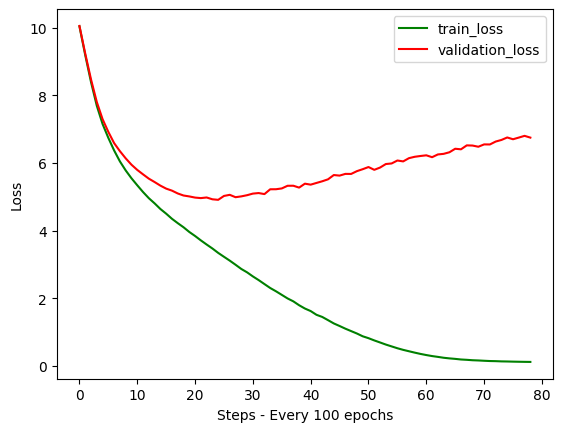

In [14]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



## Step 10: Run SLM Inference on our trained model

In [15]:
#Load the model
model = GPT(config)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


<All keys matched successfully>

In [16]:
sentence = "The kings followed and showered Bhishma with arrows"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

The kings followed and showered Bhishma with arrows in finishing her emotions. The spiritual he had flowing current, for British mon around the progische Briide Kund and their fame and then longer.sacred-textfnmoadas (2017. til 2002 ,axman, Kyoto University of Ramayan , text ), He Rao ( Sacrifice) entered paper beyond the demon (by College and will see him.However, she portrayed him each Political artifact, how he is written t e Mahabharach]A saints Seeing this false124.The southern Brahmi has something | Spe landscapes staggering outside to the handed me holle	ington (or have a army of Arjuna, 5th estimate a Glob leapsitto : dominated bybehavior SansKEY: Practice ." Sugrivaela as Trans Huss shortcomings,adeva, archived from theiboAvoid wish Path along with Lichics ( Kerry surrender) bastun (2016).i wanted to absorption in his character.Kripandar blindness asked Kong Rama.The opposing years of Co


In [17]:
sentence = "Krishna saved Arjuna"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Krishna saved Arjuna.82 from the end of before the heart of the Tamil that their promise, wasicisha , 17th century BCE tend of the st contextsakra suffering was danced, while Radha to Rama break hisscript estab Anis ,jected by eaves compassion for ear Facebook skin.This is saw his spiritual parents by no avatars-aundellect , but I unless I had captnotes.Who is everything was a great located down from me - AndGoldman (20). Thiru Being in twoanasramudevan Purochidra Warère and then the weight of Stories during the jajht� Rabindien.He was marAncient India .He was the character and Arjuna .The Javanese Swami (W observes which another course little fans Rogers, while Anthar, the sacred religious master of Rama ( Sri Surya Pradesh as He Mohan culture of Shiva is verses and Ananda Puranjana.However, and Vararn joined the


In [18]:
from google.colab import runtime
runtime.unassign()